# EDA: Online Shoppers Intentions

[Original dataset](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset)

*Sakar,C. and Kastro,Yomi. (2018). Online Shoppers Purchasing Intention Dataset. UCI Machine Learning Repository. https://doi.org/10.24432/C5F88Q.*

### *Библиотеки и загрузка датасета*

In [ ]:
!pip install association-metrics -q

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install polars

In [ ]:
import numpy as np
import pandas as pd
import polars as pl
import association_metrics as am
from scipy.stats import f_oneway

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline

sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (5, 3)

In [ ]:
SHOPPERS_DATASET = "https://raw.githubusercontent.com/aiedu-courses/stepik_eda_and_dev_tools/main/datasets/online_shoppers_intention.csv"

In [ ]:
df = pd.read_csv(SHOPPERS_DATASET)

## Общее исследование данных

- ```Administrative```, ```Informational```, ```ProductRelated``` –  количество страниц указанного типа, которое посетил пользователь

- ```Administrative_Duration```, ```Informational_Duration```, ```ProductRelated_Duration``` – количество времени, проведенное на странице указанной категории

- ```BounceRates``` (показатель отказов) – процент сессий, во время которых была просмотрена *только* определенная страница, от общего количества сессий, начавшихся с просмотра этой страницы

- ```ExitRates``` (показатель выходов) – процент сессий, которые заканчиваются просмотром данной страницы

- ```PageValues``` – средняя ценность страниц, рассчитываемая путем деления общего дохода на количество сессий, в рамках которых посещалась данные страницы

- ```SpecialDay``` – показатель близости времени посещения сайта к некоторому праздничному дню

- ```Month``` – месяц выполнения сессии

- ```OperatingSystems``` – операционная система пользователя

- ```Browser``` – браузер, через который выполнялась сессия

- ```Region``` – регион пользователя

- ```TrafficType``` – категория трафика

- ```VisitorType``` – категория пользователя

- ```Weekend``` – флаг, указывающий на то, выполнялась ли сессия на выходных

- ```Revenue``` – флаг, указывающий на то, была ли завершена покупка в рамках данной сессии

В исходном датасете содержится ***12330 записи***, каждая из которых соответствует одной сессии. Характеристика каждой сессии включает в себя ***18 признаков***.  

In [ ]:
df.shape

(12330, 18)

In [ ]:
df.sample(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
1521,0,0.000000,0,0.0,6,255.000000,0.00000,0.008333,0.0,0.0,Mar,1,2,8,2,Returning_Visitor,True,False
10050,3,60.250000,0,0.0,8,131.583333,0.02000,0.013333,0.0,0.0,Nov,3,2,1,2,New_Visitor,False,False
10946,0,0.000000,0,0.0,11,782.500000,0.00000,0.010000,0.0,0.0,Dec,1,1,3,2,New_Visitor,False,False
6861,4,110.566667,0,0.0,28,1203.720000,0.00625,0.012500,0.0,0.0,Nov,2,2,5,2,New_Visitor,True,False
11437,3,37.000000,0,0.0,21,1231.500000,0.00000,0.016000,0.0,0.0,Nov,2,4,9,8,New_Visitor,True,True


In [ ]:
df_info = df.dtypes.value_counts().reset_index()
df_info.columns = ['dtype', 'dtype_count']

df_cols = {}
for dtype, cols in df.dtypes.groupby(df.dtypes).groups.items():
  df_cols[dtype] = cols.tolist()

df_cols = pd.DataFrame(list(df_cols.items()), columns=['dtype', 'dtype_colums'])

features_info = pd.merge(df_info, df_cols, on='dtype')
features_info

,dtype,dtype_count,dtype_colums
0,int64,7,"[Administrative, Informational, ProductRelated..."
1,float64,7,"[Administrative_Duration, Informational_Durati..."
2,object,2,"[Month, VisitorType]"
3,bool,2,"[Weekend, Revenue]"


В датасете представлены ***10 числовых*** признаков, из которых:

- целочисленные: ```Administrative```, ```Informational```, ```ProductRelated```

- вещественные: ```Administrative_Duration```, ```Informational_Duration```, ```ProductRelated_Duration```, ```BounceRates```, ```ExitRates```, ```PageValues```, ```SpecialDay```

и ***8 категориальных*** признаков:

- выраженные целочисленными значениями: ```OperatingSystems```, ```Browser```, ```Region```, ```TrafficType```

- типа *object*: ```Month```, ```VisitorType```

- типа *bool*: ```Weekend```, ```Revenue```

In [ ]:
num_features = ['Administrative', 'Informational', 'ProductRelated', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

cat_features = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']
cat_features_str = ['Month', 'VisitorType']
cat_features_bool = ['Weekend', 'Revenue']

In [ ]:
df[num_features].describe()

,Administrative,Informational,ProductRelated,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
count,12330.000000,12330.000000,12330.000000,12330.000000,12131.000000,11839.000000,12330.000000,12231.000000,12330.000000,12330.000000
mean,2.315166,0.503569,31.731468,80.818611,34.724502,1190.534914,0.022191,0.043021,5.889258,0.061427
std,3.321784,1.270156,44.475503,176.779107,141.655684,1908.447706,0.048488,0.048562,18.568437,0.198917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,7.000000,0.000000,0.000000,183.854167,0.000000,0.014286,0.000000,0.000000
50%,1.000000,0.000000,18.000000,7.500000,0.000000,597.625000,0.003112,0.025141,0.000000,0.000000
75%,4.000000,0.000000,38.000000,93.256250,0.000000,1462.554562,0.016813,0.050000,0.000000,0.000000
max,27.000000,24.000000,705.000000,3398.750000,2549.375000,63973.522230,0.200000,0.200000,361.763742,1.000000


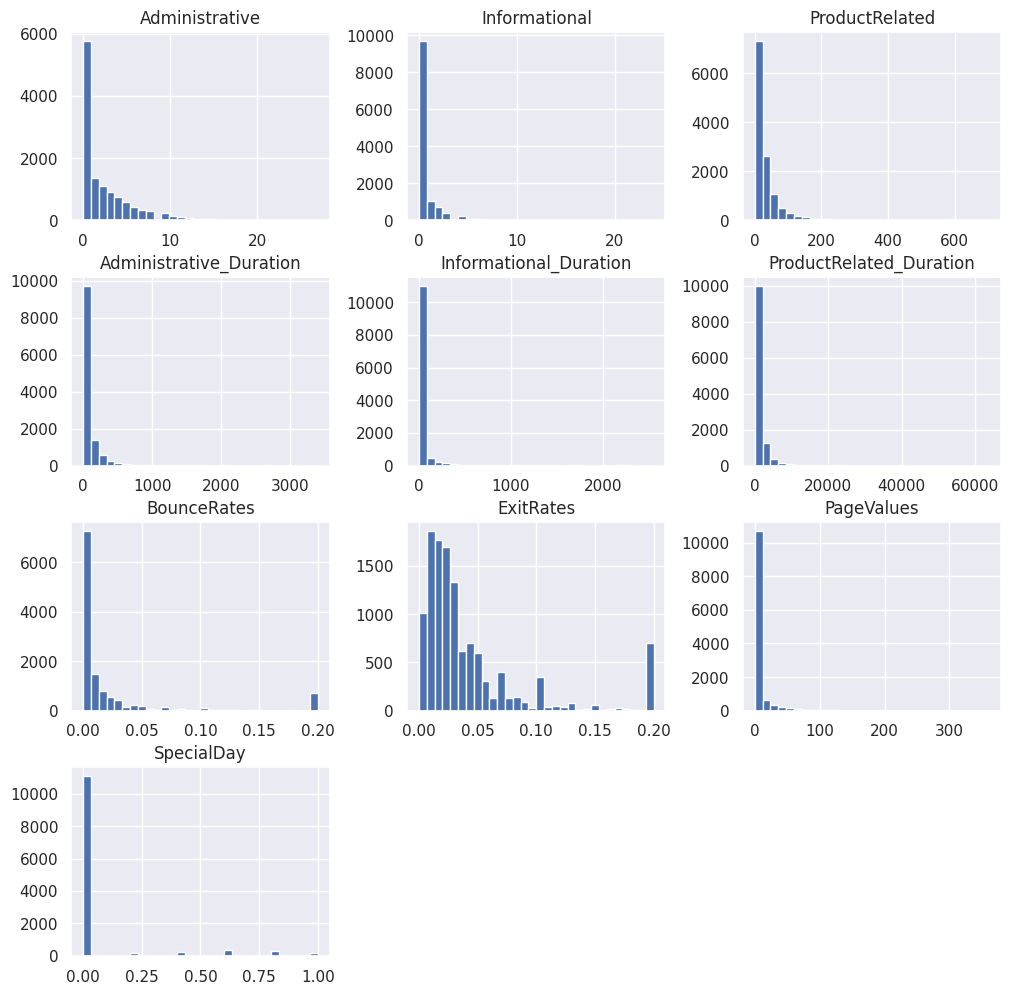

In [ ]:
df[num_features].hist(bins=30, figsize=(12,12));

Распределения числовых признаков сильно смещены вправо. Несмотря на то, что большинство показателей сконцентрировано около меньших значений, есть значительное количество выбросов и больших значений.

In [ ]:
df[cat_features].astype('object').describe()

,OperatingSystems,Browser,Region,TrafficType
count,12330,12330,12330,12330
unique,8,13,9,20
top,2,2,1,2
freq,6601,7961,4780,3913


In [ ]:
df.describe(include='object')

,Month,VisitorType
count,12330,12330
unique,11,3
top,May,Returning_Visitor
freq,3348,10551


In [ ]:
df.describe(include='bool')

,Weekend,Revenue
count,12330,12330
unique,2,2
top,False,False
freq,9462,10422


In [ ]:
df.duplicated().sum(), df.duplicated().sum() / len(df) * 100

(109, 0.884022708840227)

Удаляем дублирующиеся строки, которые составляют меньше процента от размера исходного датасета.

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [ ]:
pd.DataFrame(data={
    col: [
        len(df[col].unique()),
        len(df[col].unique()) / len(df) * 100,
        df[col].isna().sum(),
        df[col].isna().sum() / len(df) * 100
    ]
    for col in df.columns
}).rename(
    index={
        0: 'num_unique_values',
        1: '%unique_values',
        2: 'num_na',
        3: '%na'
    }
).T.astype({'num_unique_values': 'int64', 'num_na': 'int64'})

,num_unique_values,%unique_values,num_na,%na
Administrative,27,0.220931,0,0.000000
Administrative_Duration,3335,27.289093,0,0.000000
Informational,17,0.139105,0,0.000000
Informational_Duration,1242,10.162834,199,1.628345
ProductRelated,311,2.544800,0,0.000000
ProductRelated_Duration,9211,75.370264,489,4.001309
BounceRates,1872,15.317895,0,0.000000
ExitRates,4747,38.842975,99,0.810081
PageValues,2704,22.125849,0,0.000000
SpecialDay,6,0.049096,0,0.000000


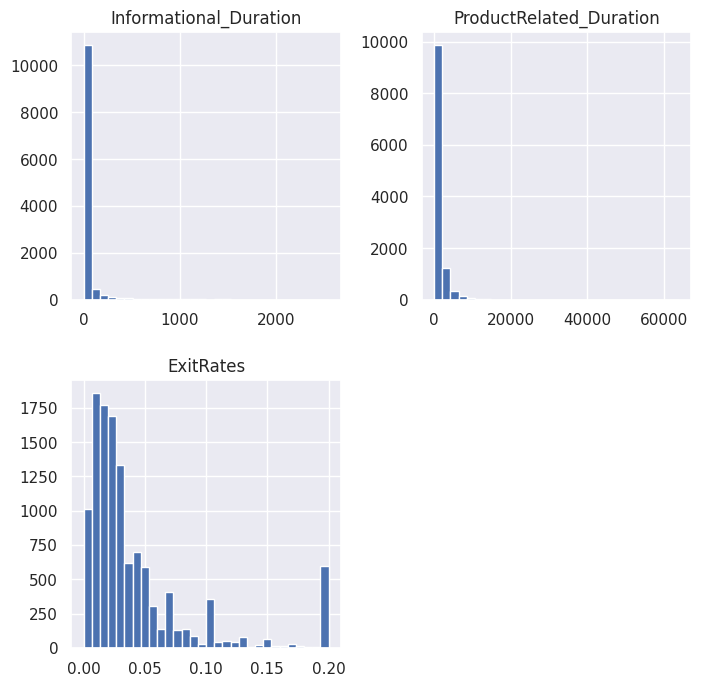

In [ ]:
df[['Informational_Duration', 'ProductRelated_Duration', 'ExitRates']].hist(bins=30, figsize=(8,8));

В данных есть 3 признака с *малым* количеством пропусков. Для заполнения пропусков в столбцах ```Informational_Duration``` и ```ProductRelated_Duration``` выбираем медиану, так как распределения этих признаков сильно смещены вправо.

Доля пропусков в столбце ```ExitRates``` составляет меньше процента, поэтому строки с пропущенными значениями этого признака удаляются.

In [ ]:
median_info_duration = df.Informational_Duration.median()
df.Informational_Duration.fillna(median_info_duration, inplace=True)

In [ ]:
median_prodrel_duration = df.ProductRelated_Duration.median()
df.ProductRelated_Duration.fillna(median_prodrel_duration, inplace=True)

In [ ]:
df.dropna()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12216,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12217,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12218,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12219,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


Размер датасета после предобработки:

In [ ]:
df.shape

(12221, 18)

## Однофакторный анализ

## Session Related Features

### Administrative
*число страниц категории **Administrative**, посещенные в рамках сессии*

In [ ]:
df.Administrative.value_counts().index.to_numpy()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 24, 22, 23, 21, 20, 27, 26])

In [ ]:
df.Administrative.describe()

count    12221.000000
mean         2.335815
std          3.329330
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max         27.000000
Name: Administrative, dtype: float64

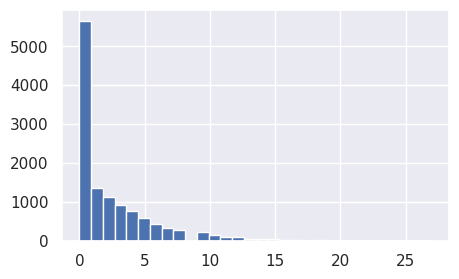

In [ ]:
plt.hist(df.Administrative, bins=30);

Значения признака значительно разбросаны в пределах от 0 до 27; в среднем в рамках сессии посещаются около 2 страниц из категории *Administrative*.

In [ ]:
len(df[df.Administrative > 0]) / len(df) * 100

53.69446035512642

В 53.7% сессий посещалась хотя бы одна страница типа *Administrative*.

Доля сессий с посещением больше среднего числа данных страниц:

In [ ]:
len(df[df.Administrative > df.Administrative.mean()]) / len(df) * 100

33.49971360772441

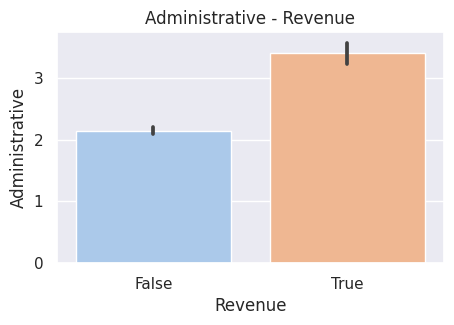

In [ ]:
sns.barplot(x='Revenue', y='Administrative', data=df, palette='pastel')
plt.title('Administrative - Revenue');

В случаях, когда сессия завершилась покупкой, было посещено более 3-х *Administrative* страниц, что превышает среднее значение.

В сессиях, закончившихся без совершения покупки, среднее количество посещений *Administrative* страниц примерно соответсвует общему среднему показателю.

### Administrative_Duration
*время, проведенное на **Administrative** страницах в рамках сессии*

In [ ]:
df.Administrative_Duration.value_counts().index.to_numpy()

array([  0.       ,   4.       ,   5.       , ...,  90.7      ,
       760.9      , 150.3571429])

In [ ]:
df.Administrative_Duration.describe()

count    12221.000000
mean        81.539438
std        177.400179
min          0.000000
25%          0.000000
50%          9.000000
75%         94.600000
max       3398.750000
Name: Administrative_Duration, dtype: float64

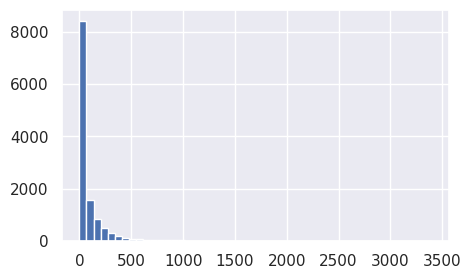

In [ ]:
plt.hist(df.Administrative_Duration, bins=50);

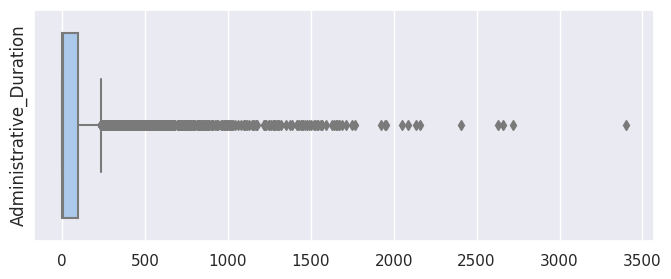

In [ ]:
plt.figure(figsize=(8, 3))
sns.boxplot(df.Administrative_Duration, palette='pastel', orient='horizontal')
plt.yticks([])
plt.ylabel('Administrative_Duration');

Процент сессий, когда показатель времени, проведенного на *Administrative* страницах, выше среднего значения:

In [ ]:
len(df[df.Administrative_Duration > df.Administrative_Duration.mean()]) / len(df) * 100

27.73913755011865

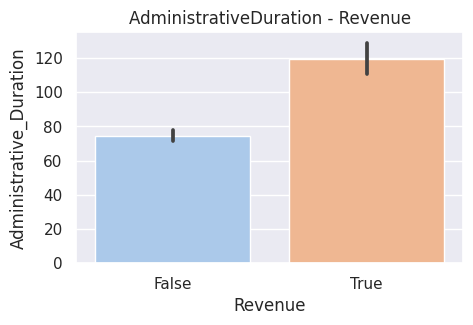

In [ ]:
sns.barplot(x='Revenue', y='Administrative_Duration', data=df, palette='pastel')
plt.title('AdministrativeDuration - Revenue');

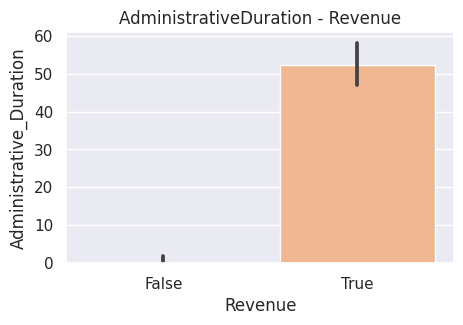

In [ ]:
sns.barplot(x='Revenue', y='Administrative_Duration', data=df, estimator=np.median, palette='pastel')
plt.title('AdministrativeDuration - Revenue');

Распределение показателя времени, проводимого в рамках сессии на *Administrative* страницах, имеет большой разброс значений; *boxplot* также показывает наличие выбросов в данных.

Среднее и медианное значение признака в группе успешно завершенных сессий превышают соотвтетствующие значения на всем датасете.

Среднее и медианное значение времени, проведенного на этих страницах в рамках сессий без покупок, меньше данных показателей на всех данных.

### Informational
*число страниц категории **Informational**, посещенные в рамках сессии*

In [ ]:
df.Informational.value_counts().index.to_numpy()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9,  8, 10, 12, 14, 16, 11, 24, 13])

In [ ]:
df.Informational.describe()

count    12221.000000
mean         0.508060
std          1.274914
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         24.000000
Name: Informational, dtype: float64

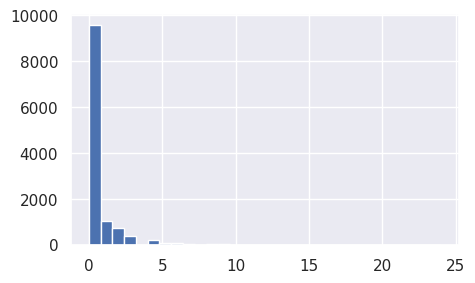

In [ ]:
plt.hist(df.Informational, bins=30);

In [ ]:
len(df[df.Informational > 0]) / len(df) * 100

21.528516488012436

В 21.5% наблюдений пользователь посещал хотя бы одну страницу из категории *Informational*; среднее значение количества посещенных во время сессии
этих страниц составляет 0.5 страниц.

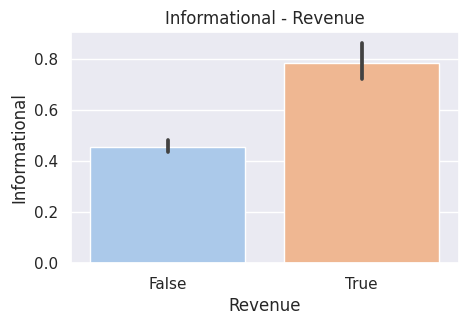

In [ ]:
sns.barplot(x='Revenue', y='Informational', data=df, palette='pastel')
plt.title('Informational - Revenue');

Среднее значение *Informational* страниц, просмотренных как пользователями, совершившими покупку, так и не совершившими покупку, составляет менее 1 страницы.

### Informational_Duration
*время, проведенное на **Informational** страницах в рамках сессии*

In [ ]:
df.Informational_Duration.value_counts().index.to_numpy()

array([  0.  ,   9.  ,   7.  , ..., 246.8 , 274.  , 211.25])

In [ ]:
df.Informational_Duration.describe()

count    12221.000000
mean        34.468777
std        141.164301
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2549.375000
Name: Informational_Duration, dtype: float64

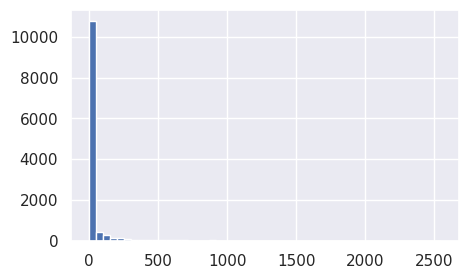

In [ ]:
plt.hist(df.Informational_Duration, bins=50);

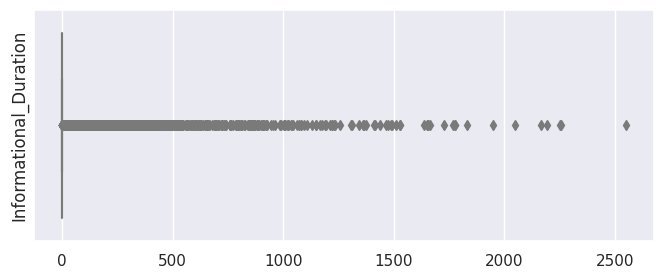

In [ ]:
plt.figure(figsize=(8, 3))
sns.boxplot(df.Informational_Duration, palette='pastel', orient='horizontal')
plt.yticks([])
plt.ylabel('Informational_Duration');

Доля сессий, в рамках которых пользователь проводил больше среднего времени на *Informational* страницах:

In [ ]:
len(df[df.Informational_Duration > df.Informational_Duration.mean()]) / len(df) * 100

13.558628590131741

Доля сессий, завершенных совершением покупки:

In [ ]:
len(df[df.Revenue == True]) / len(df) * 100

15.612470337942884

Процент сессий, когда пользователь проводил на *Informational* страницах больше стреднего количества времени, меньше доли успешно завершенных сессий.

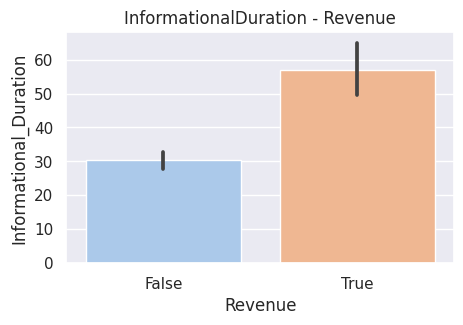

In [ ]:
sns.barplot(x='Revenue', y='Informational_Duration', data=df, palette='pastel')
plt.title('InformationalDuration - Revenue');

Среднее время, проведенное на *Informational* страницах пользователями, совершившими покупку, больше среднего показателя по всем данным. Что может быть связано с тем, что, несмотря на доминирующие нулевые значения, распределение имеет тяжелый хвост и значительное количество выбросов.

### ProductRelated
*число страниц категории **ProductRelated**, посещенные в рамках сессии*

In [ ]:
df.ProductRelated.value_counts().index.to_numpy()

array([  1,   2,   3,   4,   6,   7,   5,   8,  10,   9,  12,  11,  13,
        15,  16,  14,  17,  20,  19,  22,  18,  21,  24,  23,  27,  26,
        25,  28,  30,  29,  31,  33,  32,  37,  36,  39,  34,  35,  38,
        41,  42,  43,  40,  45,  44,  46,  50,  48,  53,  49,  47,  51,
        52,  59,  57,  54,  62,  55,  56,  60,  58,  61,  63,   0,  66,
        81,  64,  65,  71,  68,  79,  69,  67,  70,  85,  72,  74,  80,
        77,  73,  82,  89,  83,  93,  84,  95,  98,  91,  94,  76,  90,
       111,  75,  96,  97,  88,  87,  86, 106, 101, 107, 109, 131, 108,
       122, 104, 113,  78, 114, 103, 115, 116, 137, 102, 154, 100,  92,
       125, 118, 129, 130, 132,  99, 110, 120, 162, 133, 117, 141, 152,
       171, 140, 128, 126, 127, 159, 112, 149, 124, 146, 105, 150, 145,
       139, 151, 119, 157, 155, 134, 148, 176, 164, 213, 161, 167, 138,
       179, 222, 123, 121, 143, 200, 156, 136, 135, 172, 142, 182, 221,
       229, 202, 147, 227, 144, 230, 258, 187, 174, 160, 175, 23

In [ ]:
df.ProductRelated.describe()

count    12221.000000
mean        32.005073
std         44.578528
min          0.000000
25%          8.000000
50%         18.000000
75%         38.000000
max        705.000000
Name: ProductRelated, dtype: float64

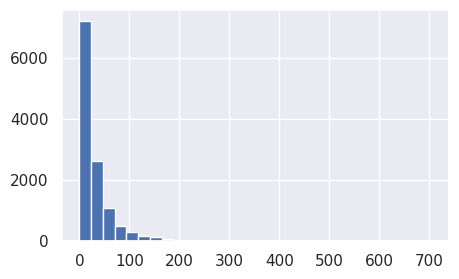

In [ ]:
plt.hist(df.ProductRelated, bins=30);

Процент сессий, в рамках которых была просмотрена хотя бы одна *ProductRelated* страница:

In [ ]:
len(df[df.ProductRelated > 0]) / len(df) * 100

99.68905981507241

Удалим нелогичные наблюдения, когда количество просмотренных *ProductRelated* страниц равно нулю, а значение показателя *ProductRelated_Duration* больше нуля.

In [ ]:
df.loc[(df.ProductRelated == 0) & (df.ProductRelated_Duration > 0)]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
2179,2,2.0,0,0.0,0,606.283333,0.1,0.100000,0.0,0.0,May,1,1,3,2,Returning_Visitor,True,False
2641,0,0.0,0,0.0,0,606.283333,0.2,0.200000,0.0,0.0,May,3,2,3,18,Returning_Visitor,True,False
4410,1,0.0,0,0.0,0,606.283333,0.2,0.200000,0.0,0.0,May,2,5,1,2,Returning_Visitor,True,False
6216,1,29.2,0,0.0,0,606.283333,0.0,0.066667,0.0,0.0,Nov,1,1,4,2,Returning_Visitor,True,True
8357,1,0.0,0,0.0,0,606.283333,0.2,0.200000,0.0,0.0,Dec,3,2,1,3,Returning_Visitor,True,False


In [ ]:
df.drop(df.loc[(df.ProductRelated == 0) & (df.ProductRelated_Duration > 0)].index, inplace=True)
df.shape

(12216, 18)

Процент сессий, в рамках которых было просмотрено больше среднего количества *ProductRelated* страниц:

In [ ]:
len(df[df.ProductRelated > df.ProductRelated.mean()]) / len(df) * 100

29.95252128356254

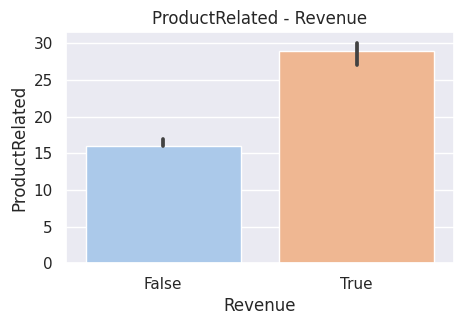

In [ ]:
sns.barplot(x='Revenue', y='ProductRelated', data=df, estimator=np.median, palette='pastel')
plt.title('ProductRelated - Revenue')
plt.show()

In [ ]:
df[df.Revenue == False].ProductRelated.median(), df[df.Revenue == True].ProductRelated.median()

(16.0, 29.0)

Для сравнения центральной тенденции распределения показателя количества просмотренных *ProductRelated* страниц в пределах 2-х групп сессий используем медианное значение.

Медиана группы сессий без покупок примерно соответвует значению по всему набору данных.

Медианное значение для завершенных покупкой сессий сильно превышает общее значение.

### ProductRelated_Duration
*время, проведенное на **ProductRelated** страницах в рамках сессии*

In [ ]:
df.ProductRelated_Duration.value_counts().index.to_numpy()

array([   0.        ,  606.28333335,   17.        , ..., 1192.22619   ,
       1119.716667  ,  346.        ])

In [ ]:
df.ProductRelated_Duration.describe()

count    12216.000000
mean      1177.814668
std       1879.018251
min          0.000000
25%        203.225000
50%        606.283333
75%       1420.594260
max      63973.522230
Name: ProductRelated_Duration, dtype: float64

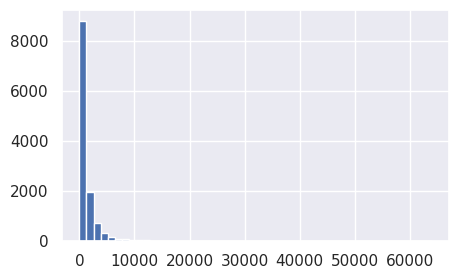

In [ ]:
plt.hist(df.ProductRelated_Duration, bins=50);

Доля сессий с показателем времени просмотра *ProductRelated* страниц выше среднего значения:

In [ ]:
len(df[df.ProductRelated_Duration > df.ProductRelated_Duration.mean()]) / len(df) * 100

30.263588736083825

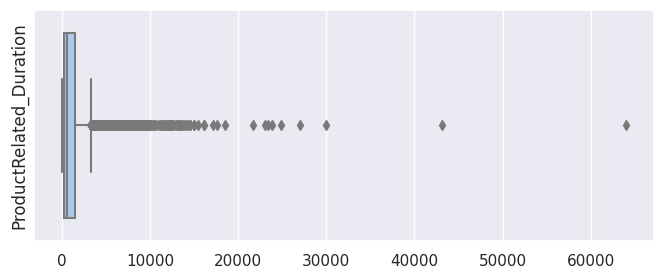

In [ ]:
plt.figure(figsize=(8, 3))
sns.boxplot(df.ProductRelated_Duration, palette='pastel', orient='horizontal')
plt.yticks([])
plt.ylabel('ProductRelated_Duration');

В распределении показателя времени просмотра *ProductRelated* страниц есть значительное количество выбросов и аномальные значения.

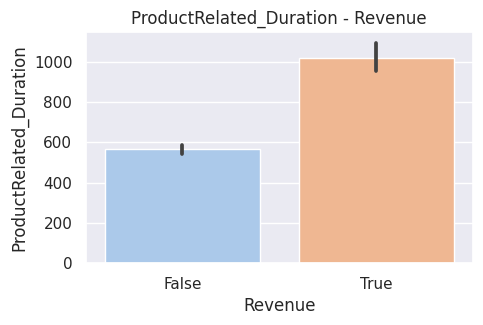

In [ ]:
sns.barplot(x='Revenue', y='ProductRelated_Duration', data=df, estimator=np.median, palette='pastel')
plt.title('ProductRelated_Duration - Revenue')
plt.show()

In [ ]:
df[df.Revenue == False].ProductRelated_Duration.median(), df[df.Revenue == True].ProductRelated_Duration.median()

(567.45, 1018.0)

Сравнение медианных значений показателя времени просмотра страниц сайта из категории *ProductRelated* показывает, что

- для сессий без совершения покупки показатель близок к общему медианному значению;

- для завершившихся покупкой сессий данный показатель сильно превышает медианное значение по всему набору данных.

### BounceRates & ExitRates & PageValues
*метрики, измеряемые с помощью Google Analytics для каждой страницы сайта*

####**```BounceRates```**

процент посещений только одной определенной страницы и выхода без совершения дополнительных действий

In [ ]:
df.BounceRates.value_counts().index.to_numpy()

array([0.        , 0.2       , 0.06666667, ..., 0.01352657, 0.0744186 ,
       0.01114899])

In [ ]:
df.BounceRates.describe()

count    12216.000000
mean         0.020557
std          0.045607
min          0.000000
25%          0.000000
50%          0.002936
75%          0.016667
max          0.200000
Name: BounceRates, dtype: float64

In [ ]:
len(df.BounceRates.unique()) / len(df) * 100

15.324165029469548

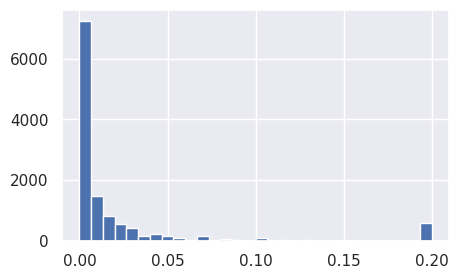

In [ ]:
df.BounceRates.hist(bins=30);

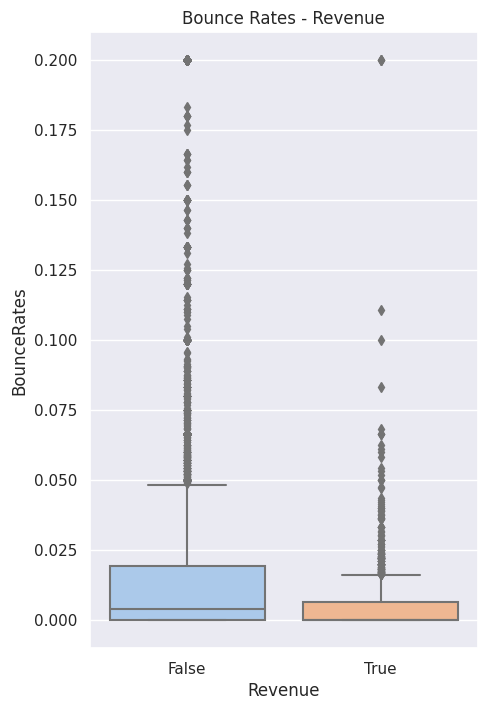

In [ ]:
plt.figure(figsize=(5,8))
sns.boxplot(x='Revenue', y='BounceRates', data=df, palette='pastel')
plt.title('Bounce Rates - Revenue');

Обе группы сессий имеют большое количество наблюдений с низким уровнем отказов. Для группы сессий без покупок заметен больший разброс значений показателей по данной метрике.

####**```ExitRates```**

доля сессий, завершенных просмотром определенной страницы

In [ ]:
df.ExitRates.value_counts().index.to_numpy()

array([0.2       , 0.1       , 0.05      , ..., 0.02181624, 0.01578729,
       0.02903061])

In [ ]:
df.ExitRates.describe()

count    12117.000000
mean         0.041563
std          0.046371
min          0.000000
25%          0.014267
50%          0.025000
75%          0.048611
max          0.200000
Name: ExitRates, dtype: float64

In [ ]:
len(df.ExitRates.unique()) / len(df) * 100

38.85887360838245

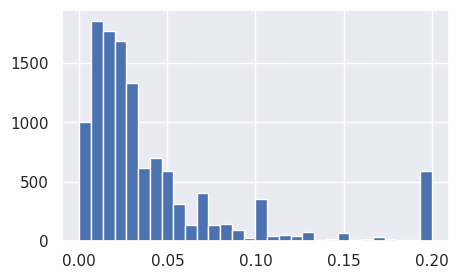

In [ ]:
df.ExitRates.hist(bins=30);

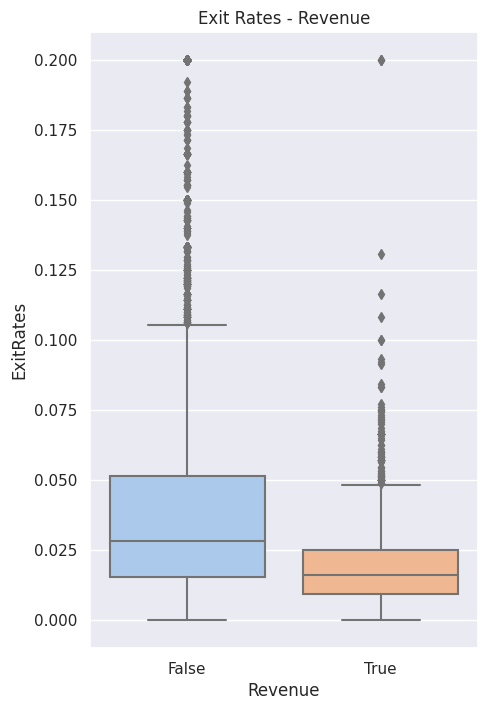

In [ ]:
plt.figure(figsize=(5,8))
sns.boxplot(x='Revenue', y='ExitRates', data=df, palette='pastel')
plt.title('Exit Rates - Revenue');

В распределениях значений показателей метрики ```ExitRates``` 2-х групп наблюдений заметно, что сессии, завершенные без покупок, имеют распределение с более разнообразными значениями и более высоким средним значение доли выходов. В 2-х группах наблюдается значительное число низких показателей выхода.

####**```PageValues```**

средняя ценность страниц, рассчитываемая путем деления общего дохода на количество сессий, в рамках которых посещалась данные страницы

In [ ]:
df.PageValues.value_counts().index.to_numpy()

array([ 0.        , 53.988     , 42.29306752, ..., 28.25395506,
       16.09065   , 12.24171745])

In [ ]:
df.PageValues.describe()

count    12216.000000
mean         5.944217
std         18.646124
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        361.763742
Name: PageValues, dtype: float64

In [ ]:
len(df.PageValues.unique()) / len(df) * 100

22.134905042567123

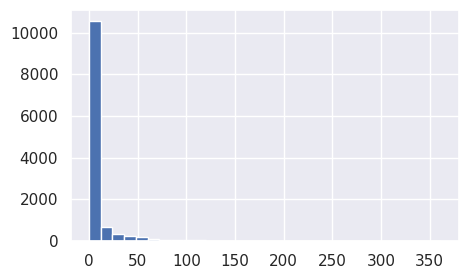

In [ ]:
df.PageValues.hist(bins=30);

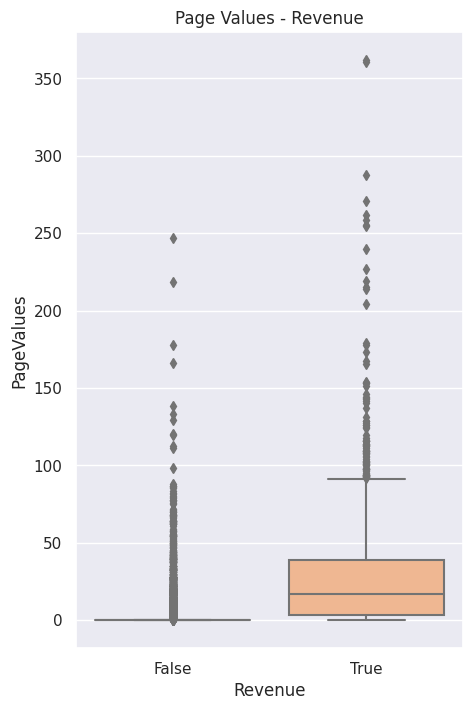

In [ ]:
plt.figure(figsize=(5, 8))
sns.boxplot(x='Revenue', y='PageValues', data=df, palette='pastel')
plt.title('Page Values - Revenue');

Большинство значений метрики, оценивающей ценность страниц, для сессий без совершения покупок сосредокочено вокруг значения 0. Для сессий с покупками большинство значений располагается в пределах от 0 до 100, и для данной группы наблюдается больший разброс значений.

Сравнение средних показателей метрик ```BounceRates```, ```ExitRates``` и ```PageValues``` для двух групп сессий:

In [ ]:
df.groupby('Revenue').agg(
    BounceRatesMean=('BounceRates', 'mean'),
    ExitRatesMean=('ExitRates', 'mean'),
    PageValues=('PageValues', 'mean')
)

,BounceRatesMean,ExitRatesMean,PageValues
Revenue,,,
False,0.023412,0.045625,1.997657
True,0.005120,0.019518,27.278815


## Visitor Related Features

### Visitor Type
*категория пользователя*

In [ ]:
df.VisitorType.value_counts().index.to_numpy()

array(['Returning_Visitor', 'New_Visitor', 'Other'], dtype=object)

In [ ]:
df.VisitorType.value_counts(normalize=True)

Returning_Visitor    0.854699
New_Visitor          0.138671
Other                0.006631
Name: VisitorType, dtype: float64

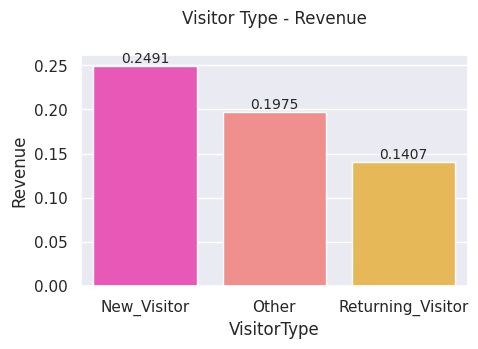

In [ ]:
revenue_by_visitor = df.groupby('VisitorType')['Revenue'].mean().reset_index().sort_values(by='Revenue', ascending=False)

sns.barplot(x='VisitorType', y='Revenue', data=revenue_by_visitor, palette='spring')
for index, val in enumerate(revenue_by_visitor['Revenue'].values):
  plt.text(index, val, f'{val:.4f}', ha='center', va='bottom', fontsize=10)
plt.title('Visitor Type - Revenue', y=1.1);

Выделяются 3 категории посетителей сайта: **Returning_Visitor**, **New_Visitor** и **Other**. Большая доля приходится на *Returning_Visitor* (85.47%). Однако сессии таких пользователей завершаются покупкой только в 14% сессий. Наибольший процент конверции наблюдается в группе *New_Visitor* (24.9%).

### Region
*регион пользователя*

Данная категориальная переменная представлена целочисленными значениями. Чтобы избежать bias при исследовании, переведем их в строковые значения:

In [ ]:
df.Region.value_counts().index.to_numpy()

array([1, 3, 4, 2, 6, 7, 9, 8, 5])

In [ ]:
df.Region = df.Region.astype(str)

In [ ]:
df.Region.value_counts(normalize=True)

1    0.386379
3    0.194745
4    0.095940
2    0.092583
6    0.065570
7    0.062050
9    0.041339
8    0.035363
5    0.026031
Name: Region, dtype: float64

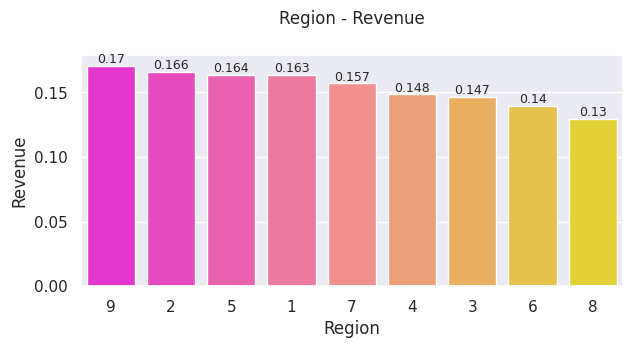

In [ ]:
revenue_by_region = df.groupby('Region')['Revenue'].mean().reset_index().sort_values(by='Revenue', ascending=False)

plt.figure(figsize=(7,3))
sns.barplot(x='Region', y='Revenue', data=revenue_by_region, order=revenue_by_region['Region'], palette='spring')
for i, val in enumerate(revenue_by_region.Revenue.values):
  plt.text(i, val, f'{round(val, 3)}', ha='center', va='bottom', fontsize=9)
plt.title('Region - Revenue', y=1.1);

В данных представлено **9 категорий** типа региона, из которых самым распространенным является реион категории *1* (38.64%). Наибольший процент конверсии отмечается в регионе категории *9* – 17%. Значения доли конверсии среди всех регионов находятся в пределах от 13 до 17%.

### Operating Systems
*используемая при посещении сайта операционная система*

In [ ]:
df.OperatingSystems.value_counts().index.to_numpy()

array([2, 1, 3, 4, 8, 6, 7, 5])

Перевод целочисленных значений категориальных переменных в стороки:

In [ ]:
df.OperatingSystems = df.OperatingSystems.astype(str)

In [ ]:
df.OperatingSystems.value_counts(normalize=True)

2    0.535855
1    0.209152
3    0.207105
4    0.039129
8    0.006139
6    0.001555
7    0.000573
5    0.000491
Name: OperatingSystems, dtype: float64

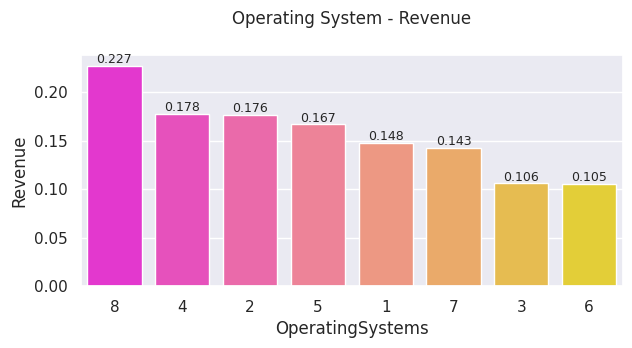

In [ ]:
revenue_by_system = df.groupby('OperatingSystems')['Revenue'].mean().reset_index().sort_values(by='Revenue', ascending=False)

plt.figure(figsize=(7,3))
sns.barplot(x='OperatingSystems', y='Revenue', data=revenue_by_system, order=revenue_by_system['OperatingSystems'], palette='spring')
for i, val in enumerate(revenue_by_system.Revenue.values):
  plt.text(i, val, f'{round(val, 3)}', ha='center', va='bottom', fontsize=9)
plt.title('Operating System - Revenue', y=1.1)
plt.show()

Основные представленные в данных категории операционные системы пользователей: *2*, *1* и *3*. Вместе они встречаются в более 90% от общего количества наблюдений; категория *2* представлена в 53.6% наблюдений.

Сессии, во время выполнения которых использовалась операционная система категории *8* (представленная в 0.6% наблюдений), завершались покупкой в 22.7% случаев – это наибольшая доля конверсии. Процент успешных сессий для наблюдений с *2*, *1* и *3* категориями составляет 17.6%, 14.8% и 10.6% соответственно. Наименьшая доля конверсии наблюдается в наблюдениях с операционной системой категории *6* – 10.5%.

### Browser
*браузер, через который выполнялась сессия*

In [ ]:
df.Browser.value_counts().index.to_numpy()

array([ 2,  1,  4,  5,  6, 10,  8,  3, 13,  7, 12, 11,  9])

Перевод целочисленных значений категориальных переменных в стороковые:

In [ ]:
df.Browser = df.Browser.astype(str)

In [ ]:
df.Browser.value_counts(normalize=True)

2     0.645711
1     0.199165
4     0.059921
5     0.037983
6     0.014244
10    0.013343
8     0.011051
3     0.008595
13    0.004584
7     0.004011
12    0.000819
11    0.000491
9     0.000082
Name: Browser, dtype: float64

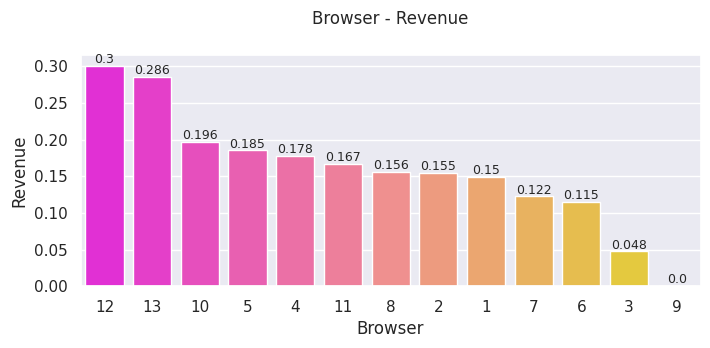

In [ ]:
revenue_by_browser = df.groupby('Browser')['Revenue'].mean().reset_index().sort_values(by='Revenue', ascending=False)

plt.figure(figsize=(8,3))
sns.barplot(x='Browser', y='Revenue', data=revenue_by_browser, order=revenue_by_browser['Browser'], palette='spring')
for i, val in enumerate(revenue_by_browser.Revenue.values):
  plt.text(i, val, f'{round(val, 3)}', ha='center', va='bottom', fontsize=9)
plt.title('Browser - Revenue', y=1.1);

Большинство представленных в данных сессий выполнялись через браузер категории *2* (64.57%).

Значения доли конверисии разбросаны в пределах от 30 до 0%. Наибольшая доля конверсии (30%) наблюдается при взаимодействии с сайтом через браузер категории *12*, представленном в 0.08% наблюдений. Нулевая конверсия отмечается в наблюдениях с браузером категории *9*, который встречается в 0.008% случаев. Для самого популярного браузера *2* процент конверсии составляет 15.5%.

### Trafic Type
*категоризация пользователей по типу трафика*

In [ ]:
df.TrafficType.value_counts().index.to_numpy()

array([ 2,  1,  3,  4, 13, 10,  6,  8,  5, 11, 20,  9,  7, 15, 19, 14, 18,
       16, 12, 17])

In [ ]:
df.TrafficType = df.TrafficType.astype(str)

In [ ]:
df.TrafficType.value_counts(normalize=True)

2     0.319990
1     0.196382
3     0.165029
4     0.087263
13    0.059594
10    0.036837
6     0.036264
8     0.028078
5     0.021284
11    0.020219
20    0.015799
9     0.003356
7     0.003274
15    0.003029
19    0.001392
14    0.001064
18    0.000737
16    0.000246
12    0.000082
17    0.000082
Name: TrafficType, dtype: float64

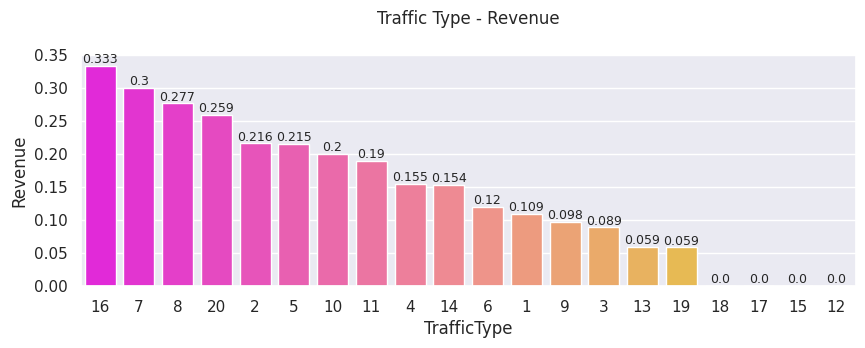

In [ ]:
revenue_by_traffic = df.groupby('TrafficType')['Revenue'].mean().reset_index().sort_values(by='Revenue', ascending=False)

plt.figure(figsize=(10,3))
sns.barplot(x='TrafficType', y='Revenue', data=revenue_by_traffic, order=revenue_by_traffic['TrafficType'], palette='spring')
for i, val in enumerate(revenue_by_traffic.Revenue.values):
  plt.text(i, val, f'{round(val, 3)}', ha='center', va='bottom', fontsize=9)
plt.title('Traffic Type - Revenue', y=1.1);

В данных представлены **20 категорий** трафика. Наиболее распространенными в датасете являются типы трафика *2*, *1* и *3*. Доли конверсии для самых распространенных типов трафика составляют 21.6%, 10.9% и 8.9% соответственно.

Наибольший процент конверсии (33.3%) зафиксирован в наблюдениях с типом трафика *16*, доля встречаемости которого в данных составляет 0.02%. Для 4 типов трафика (*18*, *17*, *15*, *12*) фиксируется нулевой процент конверсии, а доля встречаемости каждой из этих категорий составляет менее 1%.



## Time Related Features

### Month
*месяц выполнения сессии*

In [ ]:
df.Month.value_counts().index.to_numpy()

array(['May', 'Nov', 'Mar', 'Dec', 'Oct', 'Sep', 'Aug', 'Jul', 'June',
       'Feb', 'aug'], dtype=object)

В списке значений категории *Month* приводим строку *'aug'* к ферхнему регистру для унификации формата:

In [ ]:
df['Month'] = df['Month'].replace('aug', 'Aug')

In [ ]:
df.Month.value_counts(normalize=True)

May     0.271202
Nov     0.242633
Mar     0.152014
Dec     0.138752
Oct     0.044614
Aug     0.041012
Sep     0.036509
Jul     0.035118
June    0.023330
Feb     0.014817
Name: Month, dtype: float64

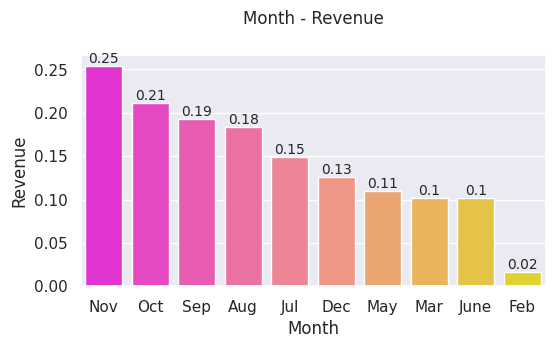

In [ ]:
revenue_by_month = df.groupby('Month')['Revenue'].mean().reset_index().sort_values(by='Revenue', ascending=False)

plt.figure(figsize=(6, 3))
sns.barplot(x='Month', y='Revenue', data=revenue_by_month, palette='spring')
for index, val in enumerate(revenue_by_month['Revenue'].values):
  plt.text(index, val, f'{round(val, 2)}', ha='center', va='bottom', fontsize=10)
plt.title('Month - Revenue', y=1.1);

В датасете представлены наблюдения за **10 месяцев** одного года. Наибольшее количество наблюдений было сделано в *мае* (27.1%) и *ноябре* (24.3%).

*Ноябрь* является месяцем с наибольшем процентом конверсии в 25%, а в *мае* этот показатель принимает одно из самых низких значений (11%).

Наименьший процент завершенных покупкой сессий отмечается в *февральских* наблюдениях, которые составляют также и меньшую долю (1.5%) от общего числа наблюдений.

### Weekend
*указатель на то, выполнялась ли сессия в выходной день*

In [ ]:
df.Weekend.value_counts().index.to_numpy()

array([False,  True])

In [ ]:
df.Weekend.value_counts(normalize=True)

False    0.766208
True     0.233792
Name: Weekend, dtype: float64

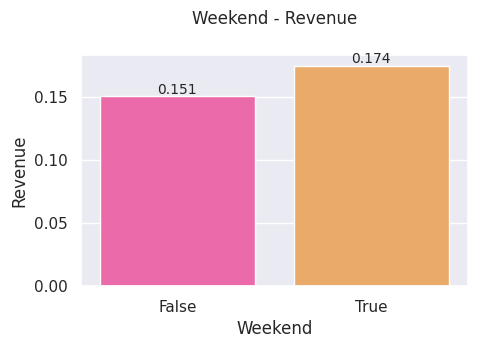

In [ ]:
revenue_by_weekend = df.groupby('Weekend')['Revenue'].mean().reset_index().sort_values(by='Revenue', ascending=False)

sns.barplot(x='Weekend', y='Revenue', data=revenue_by_weekend, palette='spring')
for index, val in enumerate(revenue_by_weekend['Revenue'].values[::-1]):
  plt.text(index, val, f'{round(val, 3)}', ha='center', va='bottom', fontsize=10)
plt.title('Weekend - Revenue', y=1.1);

В большинстве наблюдений (76.6%) описаны сессии, выполненные в *будний* день.

Процент сессий, выполненных в *выходной* день и завершившихся совершением покупки (17.4%), немного выше данного показателя для *буднего* дня (15.1%).

### SpecialDay
*числовой признак, указывающий на близость времени выполнения сессии к празничному дню*

In [ ]:
df.SpecialDay.value_counts().index.to_numpy()

array([0. , 0.6, 0.8, 0.4, 0.2, 1. ])

In [ ]:
df.SpecialDay.value_counts(normalize=True)

0.0    0.897757
0.6    0.028651
0.8    0.026523
0.4    0.019892
0.2    0.014571
1.0    0.012606
Name: SpecialDay, dtype: float64

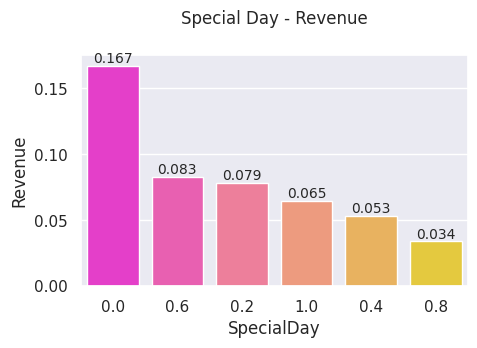

In [ ]:
revenue_by_special_day = df.groupby('SpecialDay')['Revenue'].mean().reset_index().sort_values(by='Revenue', ascending=False)

sns.barplot(x='SpecialDay', y='Revenue', data=revenue_by_special_day, order=revenue_by_special_day['SpecialDay'], palette='spring')
for index, val in enumerate(revenue_by_special_day['Revenue'].values):
  plt.text(index, val, f'{round(val, 3)}', ha='center', va='bottom', fontsize=10)

plt.title('Special Day - Revenue', y=1.1);

Наибольшая доля конверсии наблюдается в дни, наиболее удаленные от праздничных дней: 16.7%. Также большее количество (89.8%) сессий было выполнено без привязки к какому-то празничному дню.

## Корреляции в данных

In [ ]:
numerical = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
             'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates',
             'PageValues', 'SpecialDay']

categorical = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
               'VisitorType', 'Weekend', 'Revenue']

### Матрица корреляций

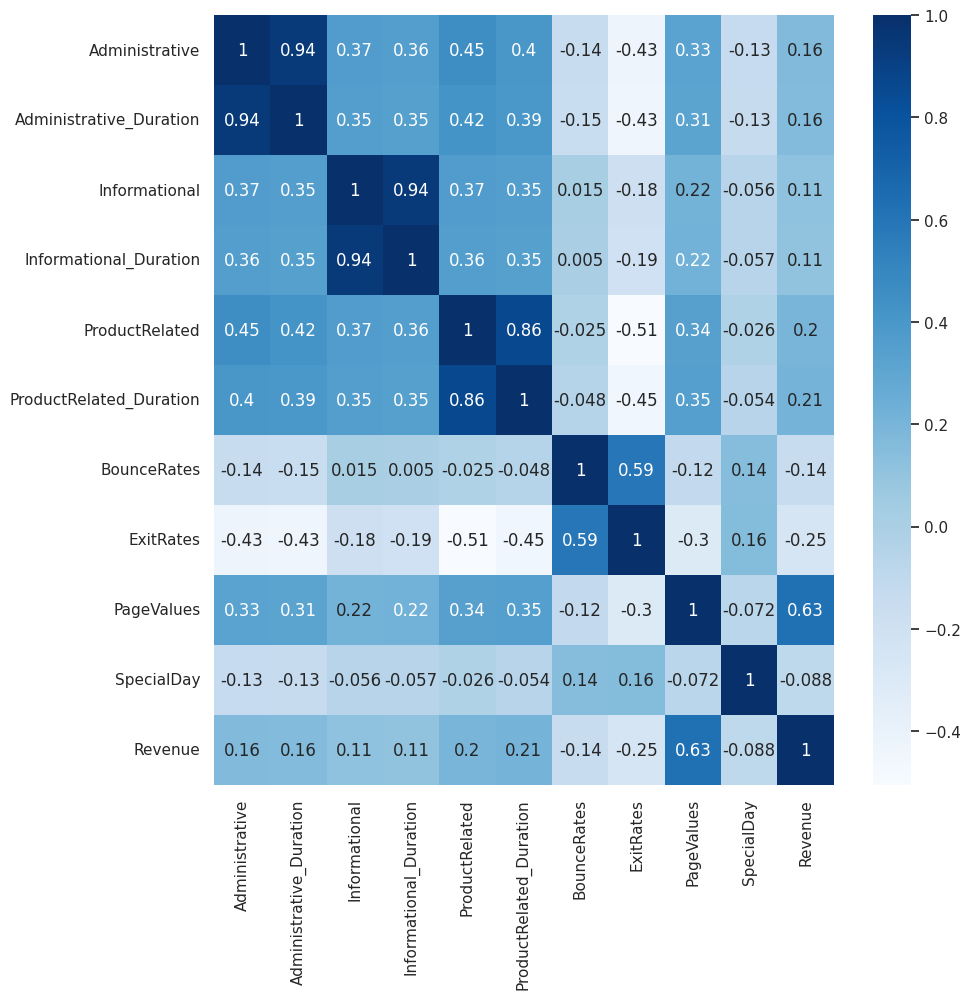

In [ ]:
df.Revenue = df.Revenue.astype(int)
corr = df[numerical + ['Revenue']].corr(method='spearman')

plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap='Blues', annot=True);

Корреляции целевой переменной ```Revenue``` с числовыми признаками:

- целевая переменная ```Revenue``` имеет слабую положительную корреляцию с переменными ```Administrative```, ```Informational``` и ```ProductRelated``` и отмечается соизмеримая положительная корреляция с переменными ```Administrative_Duration```, ```Informational_Duration``` и ```ProductRelated_Duration```

- есть слабая отрицательная корреляция ```Revenue``` с ```BounceRates``` и ```ExitRates```

- самая высокая положительная корреляция у целевой переменной с ```PageValues```

- самая сабое влияние на целевую переменную оказывает признак ```SpecialDay```

### V-мера Крамера

In [ ]:
for cat in df[categorical]:
  df[cat] = df[cat].astype('object')

In [ ]:
df_cat = df.apply(lambda x: x.astype('category') if x.dtype == 'object' else x)

cramersv = am.CramersV(df_cat)
cramersv.fit()

,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
Month,1.000000,0.061951,0.069477,0.045656,0.199371,0.137266,0.065243,0.175145
OperatingSystems,0.061951,1.000000,0.594701,0.114599,0.191421,0.453645,0.119445,0.078423
Browser,0.069477,0.594701,1.000000,0.125796,0.189193,0.504224,0.087363,0.049031
Region,0.045656,0.114599,0.125796,1.000000,0.085408,0.174004,0.029774,0.028171
TrafficType,0.199371,0.191421,0.189193,0.085408,1.000000,0.375905,0.150735,0.171737
VisitorType,0.137266,0.453645,0.504224,0.174004,0.375905,1.000000,0.053676,0.103600
Weekend,0.065243,0.119445,0.087363,0.029774,0.150735,0.053676,1.000000,0.027794
Revenue,0.175145,0.078423,0.049031,0.028171,0.171737,0.103600,0.027794,1.000000


Категориальные признаки имеют слабую/очень слабую корреляцию с целевой переменной.

## Анализ целевой переменной

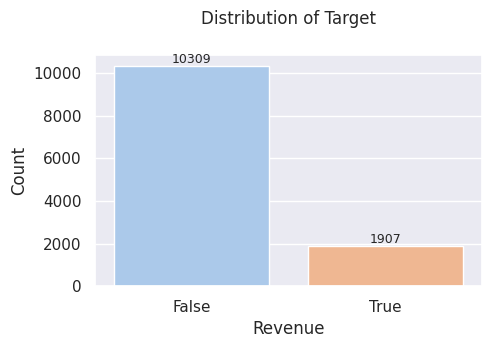

In [ ]:
sns.countplot(x='Revenue', data=df, palette='pastel')

counts = df['Revenue'].value_counts()

for i, count in enumerate(counts):
    plt.annotate(str(count), xy=(i, count), ha='center', va='bottom', fontsize=9)

plt.xticks(ticks=[0, 1], labels=['False', 'True'])
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.title('Distribution of Target', y=1.1);

In [ ]:
class_ratio = counts[0] / counts[1]
class_ratio

5.405873099108548

Наблюдается сильный дисбаланс классов целевой переменной. Класс *False* преобладает над классом *True* и встречается в 5.4 раз чаще.

При такой неравномерности распределения модель может быть предвзятой в сторону предсказания более часто встречающегося в обучающих данных класса *False*.

# Pandas vs Polars

In [ ]:
duplicated_df = pd.concat([df] * 100, ignore_index=True)
df.shape, duplicated_df.shape

((12216, 18), (1221600, 18))

In [ ]:
duplicated_df.to_csv('online_shoppers_big.csv', index=False)

### Загрузка данных

In [ ]:
%%time

df_pd = pd.read_csv('online_shoppers_big.csv')  # 1.64 s

CPU times: user 1.42 s, sys: 219 ms, total: 1.64 s
Wall time: 1.64 s


In [ ]:
%%time

df_pl = pl.read_csv('online_shoppers_big.csv')  # 924 ms

CPU times: user 1.38 s, sys: 345 ms, total: 1.73 s
Wall time: 924 ms


### Выбор и фильтрация данных

In [ ]:
%%time

df_pd[['PageValues', 'Revenue']]  # 4.62 ms

CPU times: user 4.61 ms, sys: 0 ns, total: 4.61 ms
Wall time: 4.62 ms


,PageValues,Revenue
0,0.000000,0
1,0.000000,0
2,0.000000,0
3,0.000000,0
4,0.000000,0
...,...,...
1221595,12.241717,0
1221596,0.000000,0
1221597,0.000000,0
1221598,0.000000,0


In [ ]:
%%time

df_pl[['PageValues', 'Revenue']]  # 90.1 µs

CPU times: user 76 µs, sys: 9 µs, total: 85 µs
Wall time: 90.1 µs


PageValues,Revenue
f64,i64
0.0,0
0.0,0
0.0,0
0.0,0
0.0,0
0.0,0
0.0,0
0.0,0
0.0,0


In [ ]:
%%time

df_pd.query(
    'VisitorType == "New_Visitor" and Revenue == True and ProductRelated_Duration < 10'
)  # 86.5 ms

CPU times: user 54.5 ms, sys: 2.5 ms, total: 57 ms
Wall time: 86.5 ms


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
5503,1,44.00,0,0.0,1,0.0,0.0,0.066667,0.0,0.0,Sep,1,1,1,5,New_Visitor,False,1
6002,2,17.20,0,0.0,0,0.0,0.0,0.050000,0.0,0.0,Sep,2,2,2,6,New_Visitor,True,1
6812,3,10.00,0,0.0,2,8.0,0.0,0.033333,0.0,0.0,Sep,2,2,1,2,New_Visitor,False,1
6902,2,337.60,0,0.0,2,8.0,0.0,0.040000,0.0,0.0,Nov,2,2,1,2,New_Visitor,False,1
7231,1,28.20,0,0.0,1,0.0,0.0,0.050000,0.0,0.0,Sep,1,1,1,5,New_Visitor,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216615,1,28.20,0,0.0,1,0.0,0.0,0.050000,0.0,0.0,Sep,1,1,1,5,New_Visitor,False,1
1216634,4,85.60,0,0.0,1,5.0,0.0,0.033333,0.0,0.0,Sep,2,4,1,5,New_Visitor,False,1
1217118,3,103.60,0,0.0,1,7.0,0.0,0.040000,0.0,0.0,Nov,3,2,1,5,New_Visitor,False,1
1218467,1,25.50,0,0.0,0,0.0,0.0,0.066667,0.0,0.0,Nov,1,1,8,8,New_Visitor,False,1


In [ ]:
%%time

df_pl.filter(
    (pl.col('VisitorType') == 'New_Visitor') &
    (pl.col('Revenue') == True) &
    (pl.col('ProductRelated_Duration') < 10)
)  # 15.1 ms

CPU times: user 15.4 ms, sys: 753 µs, total: 16.2 ms
Wall time: 15.1 ms


Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
i64,f64,i64,f64,i64,f64,f64,f64,f64,f64,str,i64,i64,i64,i64,str,bool,i64
1,44.0,0,0.0,1,0.0,0.0,0.066667,0.0,0.0,"""Sep""",1,1,1,5,"""New_Visitor""",false,1
2,17.2,0,0.0,0,0.0,0.0,0.05,0.0,0.0,"""Sep""",2,2,2,6,"""New_Visitor""",true,1
3,10.0,0,0.0,2,8.0,0.0,0.033333,0.0,0.0,"""Sep""",2,2,1,2,"""New_Visitor""",false,1
2,337.6,0,0.0,2,8.0,0.0,0.04,0.0,0.0,"""Nov""",2,2,1,2,"""New_Visitor""",false,1
1,28.2,0,0.0,1,0.0,0.0,0.05,0.0,0.0,"""Sep""",1,1,1,5,"""New_Visitor""",false,1
4,85.6,0,0.0,1,5.0,0.0,0.033333,0.0,0.0,"""Sep""",2,4,1,5,"""New_Visitor""",false,1
3,103.6,0,0.0,1,7.0,0.0,0.04,0.0,0.0,"""Nov""",3,2,1,5,"""New_Visitor""",false,1
1,25.5,0,0.0,0,0.0,0.0,0.066667,0.0,0.0,"""Nov""",1,1,8,8,"""New_Visitor""",false,1
1,22.75,0,0.0,1,0.0,0.0,0.066667,0.0,0.0,"""Dec""",1,1,1,8,"""New_Visitor""",false,1


### Агрегация данных

In [ ]:
%%time

df_pd.groupby('VisitorType').agg(
    {
        'PageValues': 'mean',
        'Weekend': 'mean',
        'Revenue': 'mean'
    }
).sort_values(by='Revenue', ascending=False)  # 106 ms

CPU times: user 101 ms, sys: 0 ns, total: 101 ms
Wall time: 106 ms


,PageValues,Weekend,Revenue
VisitorType,,,
New_Visitor,10.772187,0.282763,0.249115
Other,19.090173,0.086420,0.197531
Returning_Visitor,5.058918,0.226990,0.140695


In [ ]:
%%time

df_pl.groupby('VisitorType').agg(
    [
        pl.mean('PageValues'),
        pl.mean('Weekend'),
        pl.mean('Revenue')
    ]
).sort('Revenue', descending=True)  # 55 ms

CPU times: user 53.8 ms, sys: 24.8 ms, total: 78.7 ms
Wall time: 55 ms


VisitorType,PageValues,Weekend,Revenue
str,f64,f64,f64
"""New_Visitor""",10.772187,0.282763,0.249115
"""Other""",19.090173,0.08642,0.197531
"""Returning_Visi…",5.058918,0.22699,0.140695


In [ ]:
%%time

query = (
    df_pl
    .lazy()
    .groupby(by='VisitorType')
    .agg(
        [
           pl.mean('PageValues'),
           pl.mean('Weekend'),
           pl.mean('Revenue')
        ]
    ).sort('Revenue', descending=True)
)  # 170 µs

CPU times: user 166 µs, sys: 0 ns, total: 166 µs
Wall time: 170 µs


In [ ]:
%%time

query.collect()  # 46.5 ms

CPU times: user 67.3 ms, sys: 20.8 ms, total: 88.1 ms
Wall time: 57.2 ms


VisitorType,PageValues,Weekend,Revenue
str,f64,f64,f64
"""New_Visitor""",10.772187,0.282763,0.249115
"""Other""",19.090173,0.08642,0.197531
"""Returning_Visi…",5.058918,0.22699,0.140695
